
<div style="text-align: center; font-size: 20px; margin-top: 10px; margin-bottom: 20px;">
    M9 · Deep Learning aplicada – Visión artificial (Intel Scenes)
</div>
<div style="text-align: center; font-size: 36px; font-weight: bold; margin-top: 10px; margin-bottom: 20px;">
    Clasificación multiclase 150×150 · 6 etiquetas
</div>

<p style="text-align: center;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/f/fd/IMF_Smart_Education.png" alt="IMF Smart Education" width="300"/>
</p>

---

<div style="text-align: center; font-size: 28px; font-weight: bold; margin-top: 10px; margin-bottom: 20px;">
    Proyecto desarrollado por Diego Cesar Lerma Torres para IMF Smart Education
</div>

> Caso práctico del módulo **M9**  
> _Deep learning aplicada: NLP y visión artificial_  
> _Del Master en Inteligencia Artificial_

---

Este proyecto aplica técnicas avanzadas de **deep learning** para clasificar imágenes de escenas, combinando diversas áreas del conocimiento en inteligencia artificial.

# Dataset

**Intel Image Classification Dataset**

Este conjunto de datos contiene imágenes de escenas naturales alrededor del mundo, capturadas en distintas condiciones y escenarios. El objetivo es clasificar cada imagen en una de seis categorías diferentes.

- **Número de imágenes**: Aproximadamente 25,000.
- **Dimensiones**: 150x150 píxeles por imagen.
- **Categorías**:
  - 0: Buildings (edificios)
  - 1: Forest (bosque)
  - 2: Glacier (glaciar)
  - 3: Mountain (montaña)
  - 4: Sea (mar)
  - 5: Street (calle)
  
- **Estructura del dataset**:
  - **Entrenamiento (Train)**: ~14,000 imágenes.
  - **Pruebas (Test)**: ~3,000 imágenes.
  - **Predicción (Prediction)**: ~7,000 imágenes.

Cada partición está disponible en archivos comprimidos independientes.

**Fuente**: El dataset fue inicialmente publicado en [Analytics Vidhya](https://datahack.analyticsvidhya.com) por Intel como parte de un desafío de clasificación de imágenes.

**Objetivo del proyecto**:  
El propósito principal de este conjunto de datos es servir de base para el entrenamiento de redes neuronales profundas (CNNs) capaces de clasificar escenas naturales con alta precisión, fortaleciendo habilidades en visión artificial y aprendizaje profundo.

> Agradecimientos a Intel y Analytics Vidhya por proporcionar este valioso recurso para la comunidad.


# Configuración inicial

In [3]:
# !pip install -r requirements.txt

# En local
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Subir el kaggle.json, en caso de querer descargar directamente la base de datos de su origen

#from google.colab import files
#files.upload()

In [3]:
# Mover el archivo descargado a su lugar

#!mkdir -p ~/.kaggle
#!mv kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json


In [4]:
import os
import json
import zipfile
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, mixed_precision
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras_tuner as kt

mixed_precision.set_global_policy('mixed_float16')

SEED               = 42
IMG_SIZE           = (150, 150)
BATCH_SIZE         = 16
EPOCHS             = 12
VAL_SPLIT          = 0.20
TEST_SPLIT         = 0.25
AUTOTUNE           = tf.data.AUTOTUNE
PROJECT_ROOT       = Path('.')
DATA_DIR           = PROJECT_ROOT/'intel_scenes'
FULL_DATA  = DATA_DIR / 'data_all'
MODELS_DIR         = PROJECT_ROOT/'models'
HIST_DIR           = PROJECT_ROOT/'history'
for d in (DATA_DIR, FULL_DATA, MODELS_DIR, HIST_DIR):
    d.mkdir(parents=True, exist_ok=True)

random.seed(SEED);
np.random.seed(SEED);
tf.random.set_seed(SEED)
print(tf.__version__)

2.19.0


Ejecutar solo la primera vez.
Descargar y descomprimir desde Kaggle

Las siguientes veces, esta sección debe comentarse u omitirse su ejecución

In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification -p {PROJECT_ROOT}


In [6]:
with zipfile.ZipFile(PROJECT_ROOT/'intel-image-classification.zip') as z: z.extractall(DATA_DIR)


# 1. Descarga y unificación de carpetas seg_train + seg_test

In [4]:

"""# 1. Unificación de carpetas seg_train + seg_test"""

import shutil

def merge_folders_corrected(src_root: Path, dst_root: Path):
    """
    Fusiona las imágenes de las subcarpetas de clase encontradas dentro de
    src_root/seg_train/seg_train/<clase> y src_root/seg_test/seg_test/<clase>
    en dst_root/<clase>.
    Elimina las carpetas originales seg_train/ y seg_test/ de src_root después.
    """
    print(f"Iniciando fusión de carpetas desde {src_root} hacia {dst_root}")
    dst_root.mkdir(parents=True, exist_ok=True)

    split_names = ['seg_train', 'seg_test']

    for split in split_names:
        split_base_dir = src_root / split
        print(f"Procesando división: {split}")

        nested_split_dir = split_base_dir / split

        if nested_split_dir.exists() and nested_split_dir.is_dir():
            print(f"  Encontrada estructura anidada en: {nested_split_dir}")
            source_class_dir_parent = nested_split_dir
        elif split_base_dir.exists() and split_base_dir.is_dir():
             contains_class_dirs = any(item.is_dir() for item in split_base_dir.iterdir())
             if contains_class_dirs:
                 print(f"  Estructura anidada no encontrada, usando directorio base: {split_base_dir}")
                 source_class_dir_parent = split_base_dir
             else:
                 print(f"  Directorio {split_base_dir} no contiene subdirectorios de clase esperados. Omitiendo.")
                 continue
        else:
            print(f"  Directorio base {split_base_dir} no encontrado o no es un directorio. Omitiendo.")
            continue

        class_count = 0
        image_count = 0
        for class_dir in source_class_dir_parent.iterdir():
            if class_dir.is_dir():
                class_name = class_dir.name
                target_class_dir = dst_root / class_name
                target_class_dir.mkdir(parents=True, exist_ok=True)
                class_count += 1

                files_in_class = list(class_dir.iterdir())
                print(f"    Procesando clase '{class_name}' ({len(files_in_class)} archivos)...")
                for img_path in files_in_class:
                    if img_path.is_file():
                        dst_img_path = target_class_dir / img_path.name
                        try:
                            shutil.move(str(img_path), str(dst_img_path))
                            image_count += 1
                        except Exception as e:
                            print(f"      Error moviendo {img_path.name} a {target_class_dir}: {e}")

        print(f"  Procesadas {class_count} clases y {image_count} imágenes para la división '{split}'.")

    print("\nLimpiando carpetas originales...")
    for split in split_names:
        original_split_dir = src_root / split
        if original_split_dir.exists():
            try:
                shutil.rmtree(original_split_dir)
                print(f"  Eliminada carpeta: {original_split_dir}")
            except OSError as e:
                print(f"  Error eliminando {original_split_dir}: {e}")
        else:
            print(f"  La carpeta {original_split_dir} no existe, no se necesita eliminar.")

    print(f"\nFusión completada. Datos unificados en: {dst_root}")



In [ ]:
if DATA_DIR.exists():
    merge_folders_corrected(DATA_DIR, FULL_DATA)
else:
    print(f"ERROR: El directorio de origen {DATA_DIR} no existe. No se puede ejecutar la fusión.")

if FULL_DATA.exists():
    print("\nContenido del directorio unificado (data_all):")
    class_names_merged = sorted([d.name for d in FULL_DATA.iterdir() if d.is_dir()])
    print(f"Clases encontradas: {class_names_merged}")
    total_images = 0
    for class_dir in FULL_DATA.iterdir():
        if class_dir.is_dir():
            count = len(list(class_dir.glob('*.*')))
            print(f"- {class_dir.name}: {count} imágenes")
            total_images += count
    print(f"Total imágenes unificadas: {total_images}")
else:
    print(f"ERROR: El directorio destino {FULL_DATA} no se creó correctamente.")



# 2. Generadores de imágenes

In [6]:
def build_dataset(directory, img_size=IMG_SIZE, batch_size=BATCH_SIZE,
                  test_split=TEST_SPLIT, seed=SEED):

    ds_full = tf.keras.utils.image_dataset_from_directory(
        directory,
        image_size=img_size,
        batch_size=batch_size,
        shuffle=True,
        seed=seed,
        label_mode='int')

    class_names = ds_full.class_names


    total      = ds_full.cardinality().numpy()
    test_count = int(total * test_split)

    test_ds    = ds_full.take(test_count)
    train_val  = ds_full.skip(test_count)

    val_count  = int(train_val.cardinality().numpy() * VAL_SPLIT)
    val_ds     = train_val.take(val_count)
    train_ds   = train_val.skip(val_count)


    train_ds = train_ds.cache().prefetch(AUTOTUNE)
    val_ds   = val_ds.cache().prefetch(AUTOTUNE)
    test_ds  = test_ds.cache().prefetch(AUTOTUNE)

    return train_ds, val_ds, test_ds, class_names


In [7]:
train_ds, val_ds, test_ds, class_names = build_dataset(FULL_DATA)
NUM_CLASSES = len(class_names)
print(class_names)

Found 17034 files belonging to 6 classes.
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [8]:
for cls in sorted((FULL_DATA).iterdir()):
    print(f"{cls.name:<10}  {len(list(cls.glob('*'))):5d} imágenes")

# Debe mostrarse que existen varias imagenes repartidas en 6 carpetas. De lo contrario, revisar antes de comenzar el entrenamiento.

buildings    2628 imágenes
forest       2745 imágenes
glacier      2957 imágenes
mountain     3037 imágenes
sea          2784 imágenes
street       2883 imágenes


# 3. Callbacks comunes

In [9]:
def common_callbacks(name):
    return [
        EarlyStopping(patience=2, restore_best_weights=True),
        ModelCheckpoint(MODELS_DIR/f'{name}.keras', save_best_only=True),
        ReduceLROnPlateau(patience=1, factor=0.3, verbose=1)
    ]


In [10]:
def get_optimizer(lr=1e-3):
    """Crea un optimizador Adam envuelto en LossScaleOptimizer."""
    base_opt = tf.keras.optimizers.Adam(learning_rate=lr)
    return mixed_precision.LossScaleOptimizer(base_opt)

# 4. Modelo 1 — CNN Base

In [11]:
def cnn_base(input_shape=IMG_SIZE+(3,), num_classes=NUM_CLASSES):

    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),
        layers.Rescaling(1./255),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=get_optimizer(1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [12]:
base_model = cnn_base()
history_base = base_model.fit(
    train_ds, epochs=EPOCHS, validation_data=val_ds,
    callbacks=common_callbacks('base_model'))
json.dump(history_base.history, open(HIST_DIR/'base_model.json','w'))

Epoch 1/12


I0000 00:00:1745863652.858889   21159 service.cc:152] XLA service 0x7f2dcc0045e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745863652.858935   21159 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-04-28 12:07:32.901910: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745863653.011512   21159 cuda_dnn.cc:529] Loaded cuDNN version 90300


 33/640 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1948 - loss: 8.3145

I0000 00:00:1745863654.645041   21159 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4314 - loss: 2.7119

2025-04-28 12:07:39.328600: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_56', 344 bytes spill stores, 344 bytes spill loads



640/640 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4316 - loss: 2.7099 - val_accuracy: 0.6922 - val_loss: 0.8303 - learning_rate: 0.0010
Epoch 2/12
640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7771 - loss: 0.6218
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7772 - loss: 0.6216 - val_accuracy: 0.6588 - val_loss: 1.0801 - learning_rate: 0.0010
Epoch 3/12
637/640 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9318 - loss: 0.2339
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9319 - loss: 0.2335 - val_accuracy: 0.7268 - val_loss: 0.8828 - learning_rate: 3.0000e-04


# 5. Modelo 2 — CNN Avanzada (más profundidad + Dropout + BatchNorm)

In [13]:
def cnn_advanced(input_shape=IMG_SIZE+(3,), num_classes=NUM_CLASSES):
    inputs = layers.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)

    for filters in [32, 64, 128]:
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Dropout(0.25)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs, name='cnn_advanced')
    model.compile(optimizer=get_optimizer(1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [14]:
adv_model = cnn_advanced()
history_adv = adv_model.fit(
    train_ds, epochs=EPOCHS, validation_data=val_ds,
    callbacks=common_callbacks('advance_model'))
json.dump(history_adv.history, open(HIST_DIR/'advance_model.json','w'))


Epoch 1/12
640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1826 - loss: 12.6964

2025-04-28 12:07:57.815448: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_175', 4 bytes spill stores, 4 bytes spill loads

2025-04-28 12:07:57.881220: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_168', 240 bytes spill stores, 240 bytes spill loads



640/640 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.1826 - loss: 12.6970 - val_accuracy: 0.1741 - val_loss: 13.3114 - learning_rate: 0.0010
Epoch 2/12
631/640 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1772 - loss: 13.2620
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
640/640 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1771 - loss: 13.2622 - val_accuracy: 0.1741 - val_loss: nan - learning_rate: 0.0010
Epoch 3/12
639/640 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1746 - loss: 13.3041
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
640/640 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1746 - loss: 13.3043 - val_accuracy: 0.1741 - val_loss: 13.3114 - learning_rate: 3.0000e-04


# 6. Modelo 3 — Hyperparameter Tuning (Keras Tuner)

In [16]:
def model_builder(hp):
    hp_filters = hp.Choice('filters', values=[32, 48, 64])
    hp_dense   = hp.Int('dense_units', min_value=128, max_value=512, step=128)
    hp_dropout = hp.Float('dropout', 0.2, 0.5, step=0.1)
    hp_lr      = hp.Choice('lr', [1e-2, 1e-3, 1e-4])


    inputs = layers.Input(shape=IMG_SIZE + (3,))
    x = layers.Rescaling(1./255)(inputs)

    for filters in [hp_filters, hp_filters*2, hp_filters*4]:
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Dropout(hp_dropout)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(hp_dense, activation='relu')(x)
    x = layers.Dropout(hp_dropout)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    opt = get_optimizer(hp_lr)

    model.compile(
        optimizer=opt,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [17]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='kt_logs',
    project_name='intel_hp',
    overwrite=True)

SEARCH_EPOCHS = 5

print(f"Iniciando búsqueda de hiperparámetros (max_trials={tuner.oracle.max_trials}, epochs_per_trial={SEARCH_EPOCHS})...")

tuner.search(train_ds,
             epochs=SEARCH_EPOCHS,
             validation_data=val_ds,
             callbacks=[EarlyStopping(monitor='val_accuracy', patience=2)])

print("\nBúsqueda completada. Obteniendo y re-entrenando el mejor modelo...")

best_hp = tuner.get_best_hyperparameters(1)[0]
print("Mejores Hiperparámetros encontrados:")
print(best_hp.values)

best_hp_model = tuner.hypermodel.build(best_hp)

best_hp_model.save(MODELS_DIR / 'hp_best_structure_untrained.keras', include_optimizer=False)


history_hp = best_hp_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=common_callbacks('hp')
    )

json.dump(history_hp.history, open(HIST_DIR / 'hp.json', 'w'))
best_hp_model.save(MODELS_DIR / 'hp.keras')


Trial 10 Complete [00h 00m 20s]
val_accuracy: 0.18553459644317627

Best val_accuracy So Far: 0.8164308071136475
Total elapsed time: 00h 06m 31s

Búsqueda completada. Obteniendo y re-entrenando el mejor modelo...
Mejores Hiperparámetros encontrados:
{'filters': 64, 'dense_units': 384, 'dropout': 0.4, 'lr': 0.0001}
Epoch 1/12
640/640 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.4183 - loss: 1.3841 - val_accuracy: 0.6694 - val_loss: 0.8670 - learning_rate: 1.0000e-04
Epoch 2/12
640/640 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6420 - loss: 0.8925 - val_accuracy: 0.7559 - val_loss: 0.6730 - learning_rate: 1.0000e-04
Epoch 3/12
640/640 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.7483 - loss: 0.6798 - val_accuracy: 0.8062 - val_loss: 0.5517 - learning_rate: 1.0000e-04
Epoch 4/12
640/640 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8059 - loss: 0.5513 - val_accuracy: 0.8156 - val_loss: 0.5107 - learning_rate: 1.0000e-04
Epoch 5/12
640/640 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step

# 7. Modelo 4 — Transfer Learning + Fine Tuning


In [18]:
def transfer_finetune(base='MobileNetV2',
                      img_size=IMG_SIZE,
                      num_classes=NUM_CLASSES,
                      unfreeze_from=100,
                      hub_size=224):

    """Feature-extraction + fine-tuning con red pre-entrenada."""
    base_model = getattr(tf.keras.applications, base)(
        include_top=False,
        weights='imagenet',
        input_shape=(hub_size, hub_size, 3)
    )
    base_model.trainable = False

    inputs  = layers.Input(shape=img_size + (3,))
    x = layers.Resizing(hub_size, hub_size)(inputs)
    x = layers.Rescaling(1./255)(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs, name=f'{base}_finetune')

    opt_fe = get_optimizer(1e-3)
    model.compile(optimizer=opt_fe,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    hist_fe = model.fit(train_ds,
                        epochs=5,
                        validation_data=val_ds)

    opt_ft = get_optimizer(1e-5)

    base_model.trainable = True
    print(f"Fine-tuning: Descongelando desde la capa {unfreeze_from}")
    for i, layer in enumerate(base_model.layers):
        if i < unfreeze_from:
            layer.trainable = False
        else:
            if i % 10 == 0 or i >= len(base_model.layers) - 5:
              print(f"  - Capa {i} ({layer.name}): Trainable = {layer.trainable}")

    print("\nRe-compilando modelo para fine-tuning con LR bajo...")
    model.compile(optimizer=opt_ft,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


    print("Iniciando fase de fine-tuning...")
    initial_epoch_ft = hist_fe.epoch[-1] + 1

    hist_ft = model.fit(train_ds,
                        epochs=EPOCHS,
                        validation_data=val_ds,
                        callbacks=common_callbacks('fine_tuning'))

    history = {k: hist_fe.history.get(k, []) + hist_ft.history[k]
               for k in hist_ft.history.keys()
               }
    return model, history


In [19]:
tl_model, history_ft = transfer_finetune()
json.dump(history_ft, open(HIST_DIR / 'fine_tuning.json', 'w'))
tl_model.save(MODELS_DIR / 'fine_tuning.keras', include_optimizer=False)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5


2025-04-28 12:16:07.045049: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1449', 4 bytes spill stores, 4 bytes spill loads

2025-04-28 12:16:07.148869: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1449_0', 200 bytes spill stores, 536 bytes spill loads

2025-04-28 12:16:07.220225: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1449', 116 bytes spill stores, 116 bytes spill loads

2025-04-28 12:16:07.481231: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1449', 5616 bytes spill stores, 5612 bytes spill loads

2025-04-28 12:16:07.614588: I ex

638/640 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8441 - loss: 0.4435

2025-04-28 12:16:14.032823: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1449_0', 176 bytes spill stores, 524 bytes spill loads

2025-04-28 12:16:14.055351: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1449', 12 bytes spill stores, 12 bytes spill loads

2025-04-28 12:16:14.177429: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1449', 104 bytes spill stores, 104 bytes spill loads

2025-04-28 12:16:14.418061: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1449', 5144 bytes spill stores, 5204 bytes spill loads

2025-04-28 12:16:14.671121: I 

640/640 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8442 - loss: 0.4430 - val_accuracy: 0.9049 - val_loss: 0.2524
Epoch 2/5
640/640 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9194 - loss: 0.2184 - val_accuracy: 0.9076 - val_loss: 0.2571
Epoch 3/5
640/640 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9373 - loss: 0.1712 - val_accuracy: 0.9112 - val_loss: 0.2514
Epoch 4/5
640/640 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9513 - loss: 0.1369 - val_accuracy: 0.9119 - val_loss: 0.2494
Epoch 5/5
640/640 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9611 - loss: 0.1100 - val_accuracy: 0.9104 - val_loss: 0.2672
Fine-tuning: Descongelando desde la capa 100
  - Capa 100 (block_11_expand_relu): Trainable = True
  - Capa 110 (block_12_depthwise): Trainable = True
  - Capa 120 (block_13_depthwise): Trainable = True
  - Capa 130 (block_14_depthwise_relu): Trainable = True
  - Capa 140 (block_15_project): Trainable = True
  - Capa 149 (block_16_project): Trainable = True
  - Capa 150 

# 8. Modelo 5 — Data Augmentation


In [20]:
data_augmentation_layers = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal", seed=SEED),
        layers.RandomRotation(0.2, seed=SEED),
        layers.RandomZoom(0.2, seed=SEED),
        layers.RandomTranslation(height_factor=0.2, width_factor=0.2, seed=SEED),
    ],
    name="data_augmentation",
)

try:
    base_model_for_aug = tl_model
except NameError:
    print("Cargando modelo base para aumentación desde archivo...")
    base_model_for_aug = tf.keras.models.load_model(MODELS_DIR / 'fine_tuning.keras')

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation_layers(inputs, training=True)
outputs = base_model_for_aug(x)
aug_model = tf.keras.Model(inputs, outputs, name='model_with_augmentation')

aug_model.compile(optimizer=get_optimizer(1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

history_aug = aug_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=common_callbacks('data_aug')
)

json.dump(history_aug.history, open(HIST_DIR / 'data_aug.json', 'w'))
aug_model.save(MODELS_DIR / 'data_aug.keras')

Epoch 1/12
640/640 ━━━━━━━━━━━━━━━━━━━━ 43s 57ms/step - accuracy: 0.7094 - loss: 0.9075 - val_accuracy: 0.9076 - val_loss: 0.2659 - learning_rate: 1.0000e-05
Epoch 2/12
640/640 ━━━━━━━━━━━━━━━━━━━━ 34s 53ms/step - accuracy: 0.7699 - loss: 0.6226 - val_accuracy: 0.9096 - val_loss: 0.2606 - learning_rate: 1.0000e-05
Epoch 3/12
640/640 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - accuracy: 0.8076 - loss: 0.5249 - val_accuracy: 0.9064 - val_loss: 0.2574 - learning_rate: 1.0000e-05
Epoch 4/12
640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8167 - loss: 0.4880
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.
640/640 ━━━━━━━━━━━━━━━━━━━━ 35s 54ms/step - accuracy: 0.8167 - loss: 0.4880 - val_accuracy: 0.9041 - val_loss: 0.2669 - learning_rate: 1.0000e-05
Epoch 5/12
639/640 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8335 - loss: 0.4508
Epoch 5: ReduceLROnPlateau reducing learning rate to 8.999999636216671e-07.
640/640 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - accurac

# 9. Evaluación en test y comparativa final

In [23]:
def evaluate_and_log(model_path, name):
    model = tf.keras.models.load_model(model_path)
    loss, acc = model.evaluate(test_ds, verbose=0)
    return {'Model_Name': name, 'Test_Accuracy': acc}


,Model_Name,Test_Accuracy
0,base_model,0.694
1,advance_model,0.163
2,hp,0.823
3,fine_tuning,0.905
4,data_aug,0.899


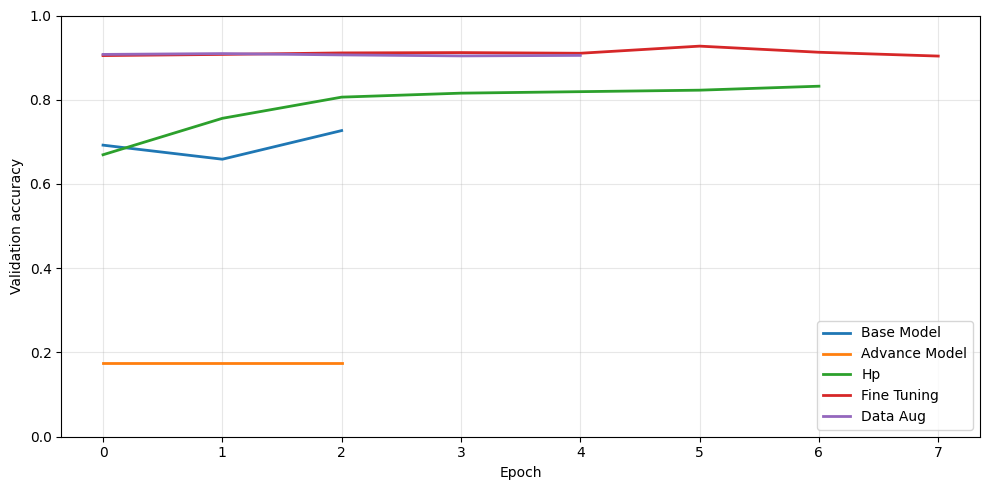

In [25]:
results = pd.DataFrame([
    evaluate_and_log(MODELS_DIR/'base_model.keras',   'base_model'),
    evaluate_and_log(MODELS_DIR/'advance_model.keras','advance_model'),
    evaluate_and_log(MODELS_DIR/'hp.keras',           'hp'),
    evaluate_and_log(MODELS_DIR/'fine_tuning.keras',  'fine_tuning'),
    evaluate_and_log(MODELS_DIR/'data_aug.keras',     'data_aug')
])

display(results.style.background_gradient(cmap='Reds', subset=['Test_Accuracy'])
                  .format({'Test_Accuracy':'{:.3f}'}))

plt.figure(figsize=(10,5))
for m, color in zip(['base_model','advance_model','hp','fine_tuning','data_aug'],
                    ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']):
    hist = json.load(open(HIST_DIR/f'{m}.json'))
    plt.plot(hist['val_accuracy'], label=m.replace('_',' ').title(), linewidth=2)
plt.legend(); plt.ylabel('Validation accuracy'); plt.xlabel('Epoch'); plt.ylim(0,1); plt.grid(alpha=.3)
plt.tight_layout(); plt.show()

# 10. Visualización rápida de predicciones con matplotlib

Model: "model_with_augmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)        │ (None, 150, 150, 3)      │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ data_augmentation (Sequential)    │ (None, 150, 150, 3)      │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ MobileNetV2_finetune (Functional) │ (None, 6)                │     2,422,726 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 6,475,096 (24.70 MB)

 Trainable params: 2,026,182 (7.73 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 4,052,370 (15.46 MB)

2025-04-28 12:23:39.424899: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


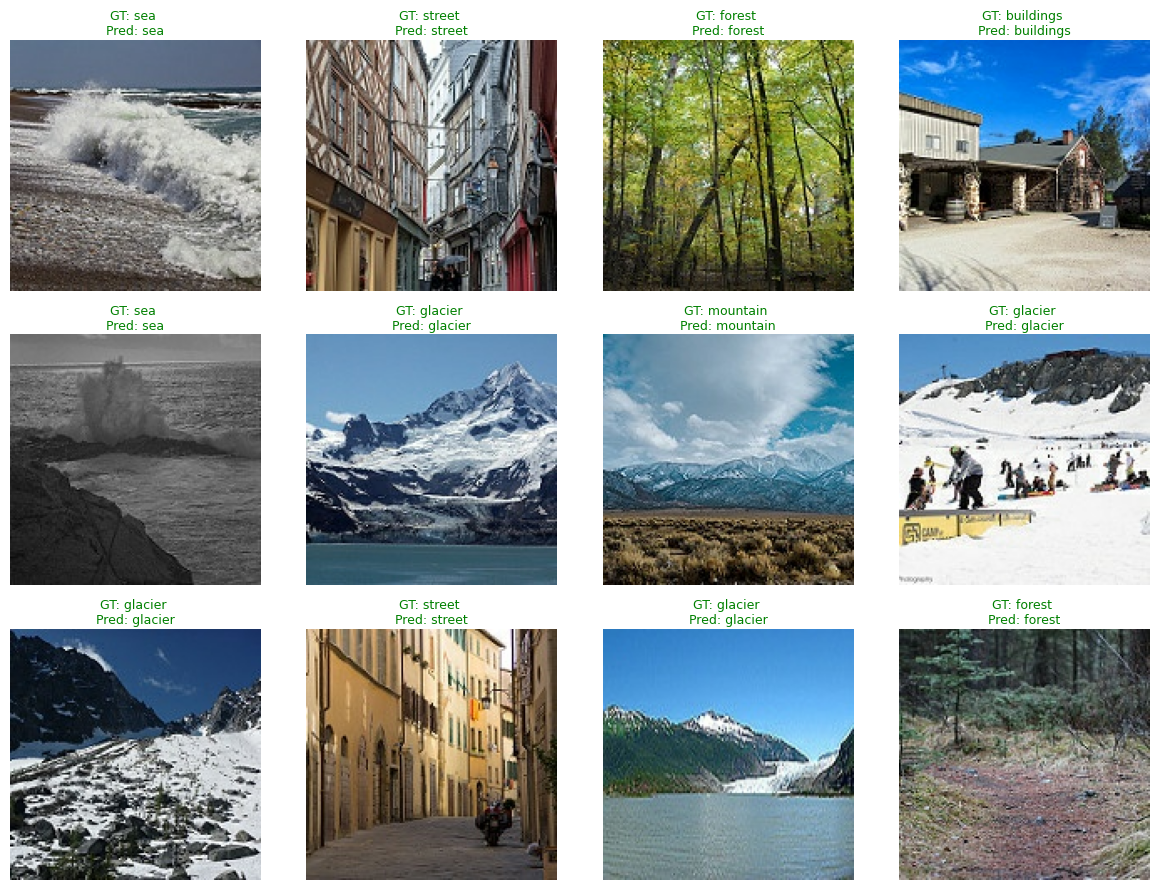

In [27]:
model  = tf.keras.models.load_model(MODELS_DIR / 'data_aug.keras')
model.summary(line_length=80)

NUM_IMAGES = 12
test_iter  = test_ds.unbatch().take(NUM_IMAGES)

plt.figure(figsize=(12, 9))
for idx, (img, true_lab) in enumerate(test_iter):
    pred_prob   = model.predict(img[tf.newaxis, ...], verbose=0)
    pred_label  = tf.argmax(pred_prob, axis=1).numpy()[0]

    ax = plt.subplot(3, 4, idx + 1)
    plt.imshow(img.numpy().astype("uint8"))
    ax.axis("off")

    correct = (pred_label == true_lab.numpy())
    color   = "green" if correct else "red"
    ax.set_title(
        f"GT: {class_names[true_lab]} \nPred: {class_names[pred_label]}",
        fontsize=9, color=color, pad=4
    )

plt.tight_layout()
plt.show()
